# Lagrangian particle tracking with ACCESS-OM2-01

Lagrangian particle tracking is widely used in a range of physical and biological oceanography applications. This [review paper](https://www.sciencedirect.com/science/article/pii/S1463500317301853) on Lagrangian fundamentals covers many of the basics and provides an overview of the different particle tracking software programs available to the oceanography community. In this notebook we'll use [Parcels](https://github.com/OceanParcels/parcels) which has the advantage of a large user community and an active development team. The [Parcels website](https://oceanparcels.org) is well documented and has some great general tutorials to get you started. In this tutorial, we'll focus on how to get a simple particle tracking experiment running with output from the ACCESS-OM2-01 model. 

**Requirements:** `conda/analysis3-25.05` (or later). This notebook was run on an xx-large ARE instance on the normal queue (**NOTE: `normal`, not `normalbw`.** An xx-large instance on normal has 48 cpus & 190gb memory, whereas an xx-large on normalbw has 28 cpus & 126gb memory) 

Firstly, load in the required modules. 

In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

from glob import glob
from datetime import timedelta
from cftime import DatetimeNoLeap
from dask.distributed import Client
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, AdvectionRK4_3D

import intake
cat = intake.cat.access_nri


It's a good idea to start a cluster with multiple cores for you to work with. 

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34127,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35119,Total threads: 1
Dashboard: /proxy/38467/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:39695,


2025-08-15 11:02:38,075 - distributed.scheduler - ERROR - Task 'finalize-hlgfinalizecompute-95c62a55a72944819822589b6d5e9ae6' has 7.81 GiB worth of input dependencies, but worker tcp://127.0.0.1:42471 has memory_limit set to 3.93 GiB. It seems like you called client.compute() on a huge collection. Consider writing to distributed storage or slicing/reducing first.


## Define the velocity fields (and any other model data) we want Parcels to read

We're now going to run some simple offline Lagrangian particle tracking experiments. This means we need to read in some velocity fields that have been output from an ocean model and feed these to Parcels. Generally speaking, you want to run Lagrangian particle tracking experiments with the highest temporal resolution available. We have several periods of daily output from ACCESS-OM2-01 available on Gadi. These are listed below.

- 21 years of daily `u`, `v`, `wt` from the **RYF** simulation corresponding to model years 50-71. This is stored in folders `output146-output279` here: `/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/`
- 31 years of daily `u`, `v`, `wt` from cycle 1 of the **IAF** simulation from 1987 to 2018. This is stored in folders `output116 - output243` here: `/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf`

We'll use the first year of the daily RYF data for this experiment. We'll also start with a simple 2D advection example, and then run a 3D particle advection experiment with temperature and salinity. 

In [3]:
dir = ! echo /scratch/$PROJECT/$USER/particle_tracking

print(f"WARNING: Output is being saved in this directory: {dir[0]} \nChange to any directory you like.")
output_directory = Path(dir[0])
output_directory.mkdir(exist_ok=True)
output_directory

Change to any directory you like.


PosixPath('/scratch/tm70/ct1163/particle_tracking')

## 2D Advection

In [4]:
experiment = "01deg_jra55v13_ryf9091"

In [5]:
%%time
experiment = "01deg_jra55v13_ryf9091"
ds = cat[experiment].search(variable=["u", "v", "wt"], frequency="1mon", start_date="19[7-9][0-9].*|200[0-1].*")
ds = ds.to_dask(
    xarray_open_kwargs= {"chunks" : "auto"}
).sel(
    yu_ocean=slice(None, -32.52)
).sel(yt_ocean=slice(None, -32.55)
).sel(time=slice(DatetimeNoLeap(1975,1,1), DatetimeNoLeap(2001,1,1))
     )

ds

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


CPU times: user 9.39 s, sys: 5.03 s, total: 14.4 s
Wall time: 9min 31s


<xarray.Dataset> Size: 910GB
Dimensions:   (time: 312, sw_ocean: 75, yt_ocean: 900, xt_ocean: 3600,
               st_ocean: 75, yu_ocean: 900, xu_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -32.71 -32.63
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 2kB 1975-01-16 12:00:00 ... 2000-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 7kB -81.09 -81.05 -81.0 ... -32.67 -32.59
  * sw_ocean  (sw_ocean) float64 600B 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables:
    wt        (time, sw_ocean, yt_ocean, xt_ocean) float32 303GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 303GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 303GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
Attributes: (12/14)
    filename:                                ocean.nc
    title:                                   ACCESS-OM2-01
    grid_type:                               mosaic
    grid_tile:                               1
    intake_esm_vars:                         ['wt', 'v', 'u']
    intake_esm_attrs:filename:               ocean.nc
    ...                                      ...
    intake_esm_attrs:variable:               age_global,average_DT,average_T1...
    intake_esm_attrs:variable_long_name:     Age (global),Length of average p...
    intake_esm_attrs:variable_cell_methods:  time: mean,,,,time: mean,time: m...
    intake_esm_attrs:realm:                  ocean
    intake_esm_attrs:_data_format_:          netcdf
    intake_esm_dataset_key:                  ocean.1mon.grid_xt_ocean:3600.gr...

In [6]:
# We now define a dictionary that tells Parcels where the U and V velocity data is,
# and where to find the coordinates. 

# Now define a dictionary that specifies the `U, V` variable names as given in the netCDF files  
variables = {'U': 'u', 'V': 'v'}

# Define a dictionary to specify the U,V dimentions. 
# See the description under the 3D advection section for why we specify sw_ocean as the depth here. 
# For further reading, also see this tutorial on the Ocean Parcels website: https://nbviewer.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_indexing.ipynb
dimensions = {
    'U': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'},
    'V': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'}
}

fieldset = FieldSet.from_xarray_dataset(ds, variables, dimensions,
                                        mesh="spherical"
                                       )
fieldset

<FieldSet>
    fields:
        <Field>
            name            : 'U'
            grid            : RectilinearZGrid(lon=array([-279.90, -279.80, -279.70, ...,  79.80,  79.90,  80.00], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -32.75, -32.67, -32.59], dtype=float32), time=array([ 0.00,  2548800.00,  5097600.00, ...,  811987200.00,  814622400.00,  817257600.00]), time_origin=1975-01-16 12:00:00, mesh='spherical')
            extrapolate time: False
            time_periodic   : False
            gridindexingtype: 'nemo'
            to_write        : False
        <Field>
            name            : 'V'
            grid            : RectilinearZGrid(lon=array([-279.90, -279.80, -279.70, ...,  79.80,  79.90,  80.00], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -32.75, -32.67, -32.59], dtype=float32), time=array([ 0.00,  2548800.00,  5097600.00, ...,  811987200.00,  814622400.00,  817257600.00]), time_origin=1975-01-16 12:00:00, mesh='spherical')
            


We need to tell Parcels that this fieldset is periodic in the zonal (east-west) direction. This is because, if the particle is close to the edge of the fieldset (but still in it), the advection scheme will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure the advection kernel can access these values.

In [7]:
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/parcels/fieldset.py:1503: FieldSetWarning: The zonal halo is located at the east and west of current grid, with a dx = lon[1]-lon[0] between the last nodes of the original grid and the first ones of the halo. In your grid, lon[1]-lon[0] != lon[-1]-lon[-2]. Is the halo computed as you expect?
  grid.add_periodic_halo(zonal, meridional, halosize)


We now need a custom kernel that can move the particle from one side of the domain to the other.

In [8]:
def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

We'll also add a recovery kernel to delete particles if they encounter the `ErrorOutOfBounds` signal from Parcels. 

In [9]:
def checkOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()

Now we can create the **Particle Set**. This contains the particle starting locations and type of particle. We'll read in the `ht` field from the model and initialise particles in a small section across the ACC.

In [10]:
%%time

ht = cat[experiment].search(variable="ht").to_dask(xarray_open_kwargs={'chunks':'auto'})
ht = ht["ht"]
ht

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


CPU times: user 6.69 s, sys: 1.78 s, total: 8.47 s
Wall time: 1min 52s


<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
dask.array<open_dataset-ht, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid

In [11]:
x1, x2 = -100.5, -100
y1, y2 = -60, -65

lons = ht.where((ht.yt_ocean<y1) & (ht.yt_ocean>y2) & (ht.xt_ocean<x2) & (ht.xt_ocean>x1), 
                drop=True).geolon_t.values.ravel()
lats = ht.where((ht.yt_ocean<y1) & (ht.yt_ocean>y2) & (ht.xt_ocean<x2) & (ht.xt_ocean>x1), 
                drop=True).geolat_t.values.ravel()

depths = np.full(len(lats), 1.)

pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=lons,            # a vector of release longitudes 
                             lat=lats,            # a vector of release latitudes
                             depth=depths,        # a vector of release depths 
                             time=0.)             # set time to start start time of daily velocity fields
pset

<ParticleSet>
    fieldset   :
        <FieldSet>
            fields:
                <Field>
                    name            : 'U'
                    grid            : RectilinearZGrid(lon=array([-280.40, -280.30, -280.20, ...,  80.30,  80.40,  80.50], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -32.75, -32.67, -32.59], dtype=float32), time=array([ 0.00,  2548800.00,  5097600.00, ...,  811987200.00,  814622400.00,  817257600.00]), time_origin=1975-01-16 12:00:00, mesh='spherical')
                    extrapolate time: False
                    time_periodic   : False
                    gridindexingtype: 'nemo'
                    to_write        : False
                <Field>
                    name            : 'V'
                    grid            : RectilinearZGrid(lon=array([-280.40, -280.30, -280.20, ...,  80.30,  80.40,  80.50], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -32.75, -32.67, -32.59], dtype=float32), time=array([ 0.00,  2548800.00,  

Plot these particles. 

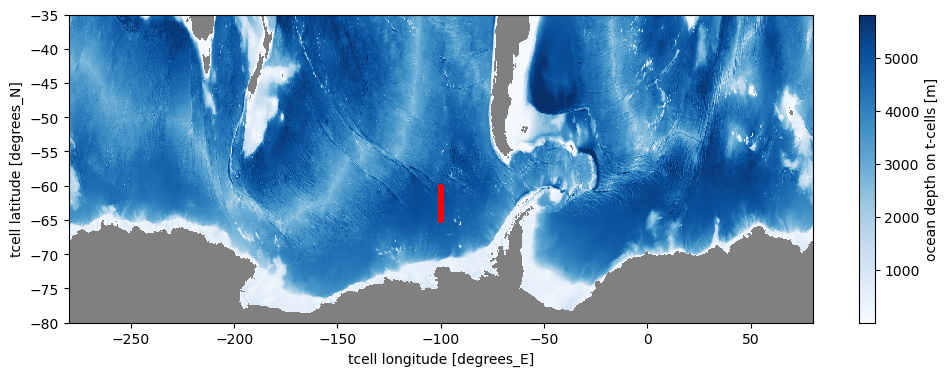

In [12]:
fig = plt.figure(figsize=(12, 4))

ht.plot(cmap='Blues')
plt.scatter(lons, lats, s=5, c='r')
plt.ylim([-80, -35]);

ax = plt.gca()
ax.set_facecolor('gray')

We can now advect these particles with Parcels. We'll do this using 4th order Runge-Kutta in 2D. In this example, we'll integrate the particle positions for only 50 days to keep it simple. This may take a few minutes depending on the resources you're using. Feel free to change the total length of the run as you like. 

**Note**: This cell might take ~5 minutes.

In [13]:
%%time
# Set your output location: 
output_filename = 'TestParticles_2D.zarr'

# the file name and the time step of the outputs 
# (particle locations will be saved every 5 days in this example)
output_file = pset.ParticleFile(
    name=output_directory / output_filename, 
    outputdt=timedelta(days=2)
) 

pset.execute(
    [
        AdvectionRK4, # the 2D advection kernel (which defines how particles move) at least one of these needs the pset.Kernel() surrounding it. 
        periodicBC ,
        checkOutOfBounds 
    ],
    runtime=timedelta(days=50),   # the total length of the run
    dt=timedelta(hours=2),        # the integration timestep of the kernels
    output_file=output_file,      # the output file
)      

INFO: Output files are stored in /scratch/tm70/ct1163/particle_tracking/TestParticles_2D.zarr.
  0%|          | 0/4320000.0 [00:00<?, ?it/s]

MemoryError: Task 'finalize-hlgfinalizecompute-95c62a55a72944819822589b6d5e9ae6' has 7.81 GiB worth of input dependencies, but worker tcp://127.0.0.1:42471 has memory_limit set to 3.93 GiB. It seems like you called client.compute() on a huge collection. Consider writing to distributed storage or slicing/reducing first.

Open output file and plot the first 100 of these trajectories. 

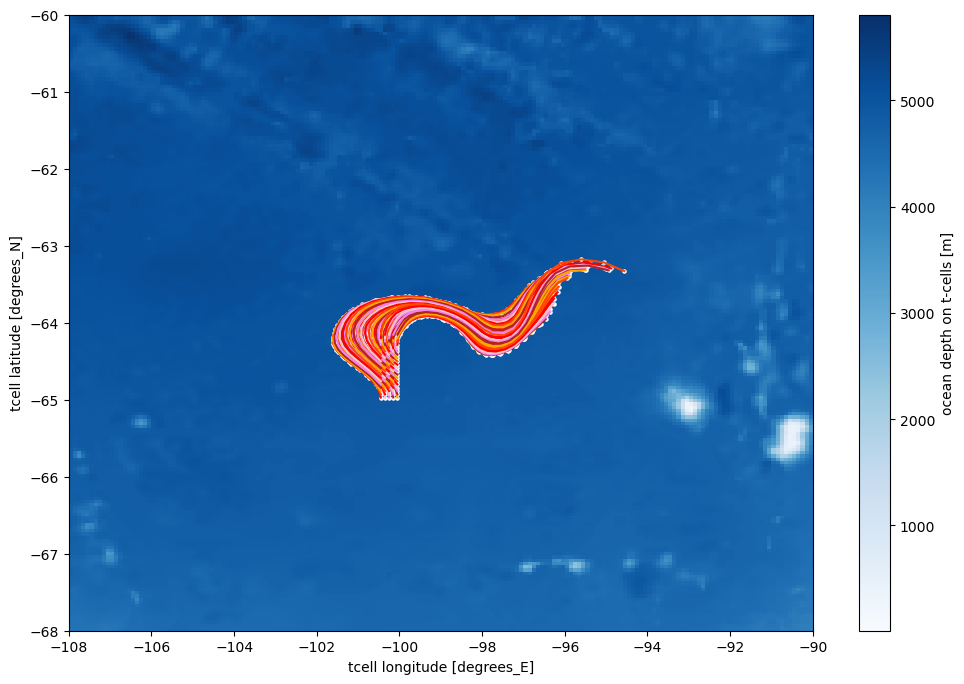

In [14]:
ds = xr.open_zarr(output_directory / output_filename)

fig = plt.figure(figsize=(12, 8))
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "pink", "violet", "firebrick", "orange", "orangered"])

ht.plot(cmap='Blues')

plt.plot(ds.lon[:100, :].T, ds.lat[:100, :].T)
plt.scatter(ds.lon[:100, :], ds.lat[:100, :], s=5, c='w')

plt.ylim([-68, -60])
plt.xlim([-108, -90]);

## 3D Advection with temperature and salinity

Now we'll run an example in 3D and also sample and save temperature and salinity fields. 

In [15]:
experiment = "01deg_jra55v13_ryf9091"

In [16]:
cat[experiment].search(variable=["u", "v", "wt", "temp", "salt"], frequency="1day",
                       # file_id='ocean.1day.nv:2.st_ocean:75.xu_ocean:3600.yu_ocean:2700',
                                    start_date = '2086.*',
                                   ).unique().file_id

['ocean.1day.nv:2.st_ocean:75.xt_ocean:3600.yt_ocean:2700',
 'ocean.1day.nv:2.st_ocean:75.xu_ocean:3600.yu_ocean:2700',
 'ocean.1day.nv:2.sw_ocean:75.xt_ocean:3600.yt_ocean:2700']

In [17]:
%%time
import warnings, dask
warnings.simplefilter(action='ignore', category=dask.array.core.PerformanceWarning)

ds3d_merge = cat[experiment].search(variable=["u", "v", "wt", "temp", "salt"], frequency="1day", 
                                    start_date = '2086.*',
                                   ).to_dataset_dict(
    xarray_open_kwargs={"decode_timedelta": True, "use_cftime": True, "chunks" : "auto"},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

CPU times: user 2.06 s, sys: 414 ms, total: 2.47 s
Wall time: 8.59 s


In [18]:
%%time
time_slice = slice(DatetimeNoLeap(2086,1,1), DatetimeNoLeap(2087,1,1))
# y_slice = slice(None, -32.52)
y_slice = slice(None, -47.0)
ds3d = xr.combine_by_coords(ds3d_merge.values(), combine_attrs="drop_conflicts").sel(yu_ocean=y_slice).sel(yt_ocean=y_slice).sel(
    time=time_slice
)

ds3d

CPU times: user 153 ms, sys: 34.3 ms, total: 188 ms
Wall time: 566 ms


<xarray.Dataset> Size: 1TB
Dimensions:   (time: 365, st_ocean: 75, yt_ocean: 711, xt_ocean: 3600,
               sw_ocean: 75, yu_ocean: 711, xu_ocean: 3600)
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 3kB 2086-01-01 12:00:00 ... 2086-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 6kB -81.11 -81.07 -81.02 ... -47.12 -47.05
  * sw_ocean  (sw_ocean) float64 600B 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 6kB -81.09 -81.05 -81.0 ... -47.08 -47.01
Data variables:
    salt      (time, st_ocean, yt_ocean, xt_ocean) float32 280GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 280GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
    wt        (time, sw_ocean, yt_ocean, xt_ocean) float32 280GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(2, 14, 600, 800), meta=np.ndarray>
Attributes: (12/14)
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    NCO:                                      netCDF Operators version 4.7.7 ...
    intake_esm_attrs:frequency:               1day
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_vars:                          ['wt']
    intake_esm_attrs:variable:                sw_ocean,time,time_bounds,wt,xt...
    intake_esm_attrs:variable_long_name:      ucell zstar depth,time,time axi...
    intake_esm_attrs:variable_standard_name:  ,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,time: mean,,
    intake_esm_attrs:variable_units:          meters,days since 1900-01-01 00...

We now need to set up the Parcels `FieldSet`. For 3D advection we also need a vertical velocity field (`W`), and in this example we'll add temperature and salinity as well.

**Note:** Initialising the `FieldSet` can take some time depending on the domain and number of files you're feeding to Parcels. In this example, it should be quick. 

We need to create `ds3d_simplified` as it let's us push everything onto the same cordinate grid.

In [19]:
ds3d_simplified = xr.Dataset(
    coords={
        "xu_ocean": ds3d["xu_ocean"], 
        "yu_ocean": ds3d["yu_ocean"], 
        "st_ocean": ds3d["st_ocean"], 
        "time": ds3d["time"]},
    data_vars={
        "u": (("time", "st_ocean", "yu_ocean", "xu_ocean"), ds3d["u"].data),
        "v": (("time", "st_ocean", "yu_ocean", "xu_ocean"), ds3d["v"].data),
        "wt": (("time", "st_ocean", "yu_ocean", "xu_ocean"), ds3d["wt"].data),
        "salt": (("time", "st_ocean", "yu_ocean", "xu_ocean"), ds3d["salt"].data),
        "temp": (("time", "st_ocean", "yu_ocean", "xu_ocean"), ds3d["temp"].data),
    },    
)
ds3d_simplified = ds3d_simplified.chunk({
    "xu_ocean": 400,
    "yu_ocean": 300,
    "st_ocean": 7,
    "time": 1,
})
ds3d_simplified

<xarray.Dataset> Size: 1TB
Dimensions:   (time: 365, st_ocean: 75, yu_ocean: 711, xu_ocean: 3600)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 6kB -81.09 -81.05 -81.0 ... -47.08 -47.01
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 3kB 2086-01-01 12:00:00 ... 2086-12-31 12:00:00
Data variables:
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    wt        (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    salt      (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>
    temp      (time, st_ocean, yu_ocean, xu_ocean) float32 280GB dask.array<chunksize=(1, 7, 300, 400), meta=np.ndarray>

In [20]:
%%time

# Now define a dictionary that specifies the (U, V, W etc) variable names as given in the netCDF files
variables = {'U': 'u',
             'V': 'v',
             'W': 'wt',
             'T': 'temp',
             'S': 'salt',
             }

dimensions = {'U': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'},
              'V': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'},
              'W': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'},
              'T': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'},
              'S': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'st_ocean', 'time': 'time'},
              }


# Finally, we load the fieldset using the Parcels `FieldSet.from_xarray_dataset` function. 
fieldset = FieldSet.from_xarray_dataset(
    ds3d_simplified, variables, dimensions,
    mesh = 'spherical', 
)


fieldset

CPU times: user 44.2 ms, sys: 4.44 ms, total: 48.6 ms
Wall time: 102 ms


<FieldSet>
    fields:
        <Field>
            name            : 'U'
            grid            : RectilinearZGrid(lon=array([-279.90, -279.80, -279.70, ...,  79.80,  79.90,  80.00], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -47.15, -47.08, -47.01], dtype=float32), time=array([ 0.00,  86400.00,  172800.00, ...,  31276800.00,  31363200.00,  31449600.00]), time_origin=2086-01-01 12:00:00, mesh='spherical')
            extrapolate time: False
            time_periodic   : False
            gridindexingtype: 'nemo'
            to_write        : False
        <Field>
            name            : 'V'
            grid            : RectilinearZGrid(lon=array([-279.90, -279.80, -279.70, ...,  79.80,  79.90,  80.00], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -47.15, -47.08, -47.01], dtype=float32), time=array([ 0.00,  86400.00,  172800.00, ...,  31276800.00,  31363200.00,  31449600.00]), time_origin=2086-01-01 12:00:00, mesh='spherical')
            extrapolate 

As for the 2D advection case, we need to tell Parcels that this fieldset is periodic in the zonal (east-west) direction. This is because, if the particle is close to the edge of the fieldset (but still in it), the advection scheme will need to interpolate velocities that may lay outside the fieldset domain. With the halo, we make sure the advection kernel can access these values.

In [21]:
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/parcels/fieldset.py:1503: FieldSetWarning: The zonal halo is located at the east and west of current grid, with a dx = lon[1]-lon[0] between the last nodes of the original grid and the first ones of the halo. In your grid, lon[1]-lon[0] != lon[-1]-lon[-2]. Is the halo computed as you expect?
  grid.add_periodic_halo(zonal, meridional, halosize)


We now need to define a particle class that tells Parcels each particle has a temperature and salinity value associated with it. We also need to define a kernel to tell Parcels to sample the temperature and salinity fields at each integration timestep. 

In [22]:
# Parcels will automatically save the latitude, longitude, and depth to file at a timestep that 
# you specify (see cells below). This kernel tells Parcels to also save the temperature and salinity fields
# to file, along with the location data. 
class SampleParticle(JITParticle):
    thermo = Variable('thermo', dtype=np.float32, initial = 0.0)
    psal = Variable('psal', dtype=np.float32, initial = 0.0)

# Kernel to sample temperature and salinity (if you have fed them into your FieldSet above).
def SampleFields(particle, fieldset, time):
    particle.thermo = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.psal =   fieldset.S[time, particle.depth, particle.lat, particle.lon]

Now we can create the **Particle Set**. Well use the same particle set as in the 2D example but this time we'll initialise particles at 10m depth. This time you can see that `thermo` and `psal` have been added to the Particle Set. 

In [23]:
%%time

ht = cat[experiment].search(variable="ht").to_dask()

x1, x2 = -100.5, -100
y1, y2 = -60, -61

lons = ht.where((ht.yt_ocean<y1) & (ht.yt_ocean>y2) & (ht.xt_ocean<x2) & (ht.xt_ocean>x1), 
                drop=True).geolon_t.values.ravel()

lats = ht.where((ht.yt_ocean<y1) & (ht.yt_ocean>y2) & (ht.xt_ocean<x2) & (ht.xt_ocean>x1), 
                drop=True).geolat_t.values.ravel()

depths = np.full(len(lats), 10.)

pset = ParticleSet.from_list(fieldset=fieldset,      # the fields on which the particles are advected
                             pclass=SampleParticle,  # the type of particles we specified above with temp and salt added
                             lon=lons,               # a vector of release longitudes 
                             lat=lats,               # a vector of release latitudes
                             depth=depths,           # a vector of release depths 
                             time=0.)                # set time to start start time of daily velocity fields
pset

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


CPU times: user 6.43 s, sys: 1.48 s, total: 7.91 s
Wall time: 1min 43s


<ParticleSet>
    fieldset   :
        <FieldSet>
            fields:
                <Field>
                    name            : 'U'
                    grid            : RectilinearZGrid(lon=array([-280.40, -280.30, -280.20, ...,  80.30,  80.40,  80.50], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -47.15, -47.08, -47.01], dtype=float32), time=array([ 0.00,  86400.00,  172800.00, ...,  31276800.00,  31363200.00,  31449600.00]), time_origin=2086-01-01 12:00:00, mesh='spherical')
                    extrapolate time: False
                    time_periodic   : False
                    gridindexingtype: 'nemo'
                    to_write        : False
                <Field>
                    name            : 'V'
                    grid            : RectilinearZGrid(lon=array([-280.40, -280.30, -280.20, ...,  80.30,  80.40,  80.50], dtype=float32), lat=array([-81.09, -81.05, -81.00, ..., -47.15, -47.08, -47.01], dtype=float32), time=array([ 0.00,  86400.00,  172800.0

For the 3D advection we will integrate particles forward-in-time for 20 days to keep this example simple, but feel free to integrate longer! If you want really long integrations you should consider [submitting the analysis as a job on Gadi](https://cosima-recipes.readthedocs.io/en/latest/tutorials/Submitting_analysis_jobs_to_gadi.html#gallery-tutorials-submitting-analysis-jobs-to-gadi-ipynb) or to some other HPC system of your liking.

**Note 1**: Generally you want to use a small integration timestep (`dt`). This is because, the larger the `dt`, the further particles will move in a single timestep and the more likely you are to get particles crossing ocean-land boundaries and 'beaching'. For example, in some Lagrangian applications it is common to use `dt` <= 15 minutes. However the choice of `dt` has to be balanced against the computational resources and the available simulation time. In this example, we'll use a `dt` of 2 hours to speed up the integration. If you want to integrate particles backwards-in-time, simple feed Parcels a negative `dt` value. 

**Note 2**: This 3D example may take some time (~5-10 minutes) depending on the resources you're using.

In [24]:
%%time
# Set your output location: 
output_filename = 'TestParticles_3D.zarr'

# the file name and the time step of the outputs 
# (particle locations will be saved every 1 days in this example)
output_file = pset.ParticleFile(name=output_directory / output_filename, 
                                outputdt=timedelta(days=1),
                               )

pset.execute(
    [
        AdvectionRK4_3D, # the 3D advection kernel (which defines how particles move)
        periodicBC,
        SampleFields,
        checkOutOfBounds
    ],
     runtime=timedelta(days=10),   # the total length of the run
     dt=timedelta(hours=0.5),        # the integration timestep of the kernel
     output_file=output_file,      # the output file
)      


INFO: Output files are stored in /scratch/tm70/ct1163/particle_tracking/TestParticles_3D.zarr.


INFO:parcels.tools.loggers:Output files are stored in /scratch/tm70/ct1163/particle_tracking/TestParticles_3D.zarr.



  0%|          | 0/864000.0 [00:00<?, ?it/s]

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 19.34 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



  0%|          | 1800.0/864000.0 [28:15<225:34:16,  1.06it/s]
 10%|█         | 86400.0/864000.0 [28:15<2:59:09, 72.34it/s] 
 20%|██        | 172800.0/864000.0 [28:16<1:05:23, 176.17it/s]
 30%|███       | 259200.0/864000.0 [28:16<31:05, 324.22it/s]  
 40%|████      | 345600.0/864000.0 [28:17<16:08, 535.29it/s]
 50%|█████     | 432000.0/864000.0 [28:18<08:37, 835.38it/s]
 60%|██████    | 518400.0/864000.0 [28:18<04:34, 1260.98it/s]
 70%|███████   | 604800.0/864000.0 [28:20<02:19, 1859.97it/s]
 80%|████████  | 691200.0/864000.0 [28:20<01:03, 2709.16it/s]
 90%|█████████ | 777600.0/864000.0 [28:21<00:22, 3900.24it/s]
100%|██████████| 864000.0/864000.0 [28:22<00:00, 507.60it/s] 
CPU times: user 2min, sys: 43.1 s, total: 2min 43s
Wall time: 28min 35s


Open output file and scatter plot the first 100 of these trajectories, coloured by depth. 

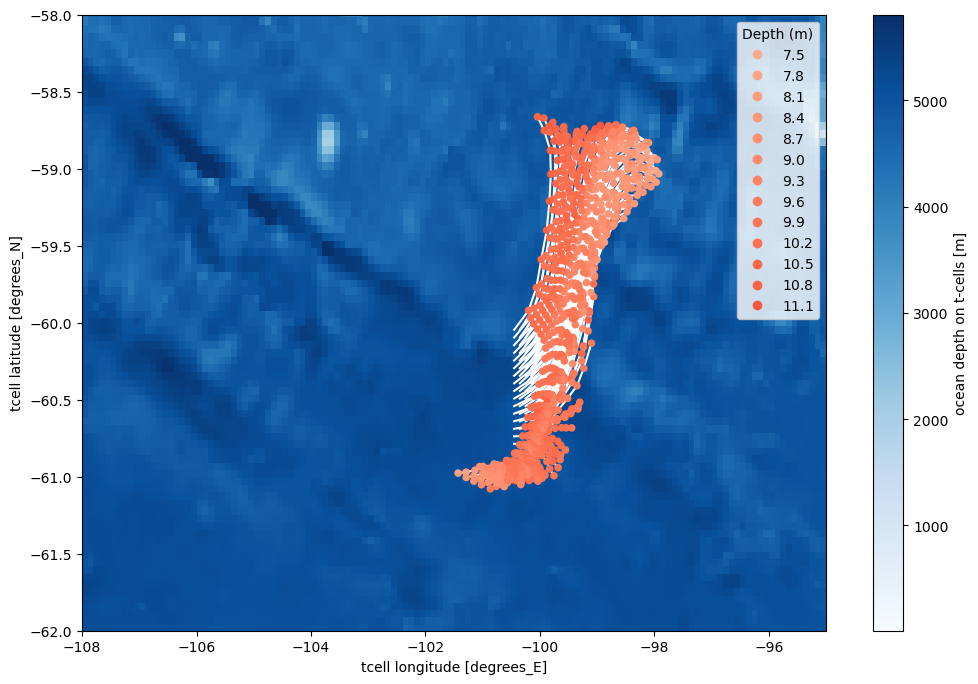

In [25]:
ds = xr.open_zarr(output_directory / output_filename)

fig = plt.figure(figsize=(12, 8))

ht['ht'].plot(cmap='Blues')

plt.plot(ds.lon[:100, :].T, ds.lat[:100, :].T, c='w', zorder=2)

cb = plt.scatter(ds.lon[:100, 1:], ds.lat[:100, 1:], c=ds.z[:100, 1:],
                 s=20, vmin=3, vmax=18, cmap='Reds', zorder=3)

plt.legend(*cb.legend_elements(num=10), loc="upper right", title="Depth (m)")

plt.ylim([-62, -58])
plt.xlim([-108, -95]);

For reference, this is how the output file is organised. 

In [26]:
ds

<xarray.Dataset> Size: 29kB
Dimensions:     (trajectory: 100, obs: 10)
Coordinates:
  * obs         (obs) int32 40B 0 1 2 3 4 5 6 7 8 9
  * trajectory  (trajectory) int64 800B 540 541 542 543 544 ... 636 637 638 639
Data variables:
    lat         (trajectory, obs) float32 4kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 4kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    psal        (trajectory, obs) float32 4kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    thermo      (trajectory, obs) float32 4kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    time        (trajectory, obs) object 8kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 4kB dask.array<chunksize=(100, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3DperiodicBCSampleFiel...
    parcels_mesh:           spherical
    parcels_version:        3.1.4